In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

import keras
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping
import tensorflow
import xgboost as xgb
import lightgbm as lgb

In [2]:
# Data is available on Github repository
df = pd.read_parquet("training_data_enriched.parquet")

In [3]:
df.head()

date symbol       revenue  costOfRevenue   grossProfit  \
0  2023-09-29   AAPL  383285000000   214137000000  169148000000   
1  2022-09-23   AAPL  394328000000   223546000000  170782000000   
2  2021-09-24   AAPL  365817000000   212981000000  152836000000   
3  2020-09-25   AAPL  274515000000   169559000000  104956000000   
4  2022-12-30   META  116609000000    25249000000   91360000000   

   researchAndDevelopmentExpenses  generalAndAdministrativeExpenses  \
0                    2.991500e+10                                 0   
1                    2.625100e+10                                 0   
2                    2.191400e+10                                 0   
3                    1.875200e+10                                 0   
4                    3.533800e+10                       11816000000   

   sellingAndMarketingExpenses  sellingGeneralAndAdministrativeExpenses  \
0                            0                              24932000000   
1                            0                              25094000000   
2                            0                              21973000000   
3                            0                              19916000000   
4                  15262000000                              27078000000   

   otherExpenses  ...  dividendsPaid  otherFinancingActivites  \
0      382000000  ...   -15025000000              -6012000000   
1      228000000  ...   -14841000000              -2428000000   
2      -60000000  ...   -14467000000              -4558000000   
3       87000000  ...   -14081000000              -2880000000   
4     -320000000  ...              0              -3251000000   

   netCashUsedProvidedByFinancingActivities  effectOfForexChangesOnCash  \
0                             -108488000000                           0   
1                             -110749000000                           0   
2                              -93353000000                           0   
3                              -86820000000                           0   
4                              -22136000000                  -638000000   

   cashAtEndOfPeriod  cashAtBeginningOfPeriod  operatingCashFlow  \
0        30737000000              24977000000       110543000000   
1        24977000000              35929000000       122151000000   
2        35929000000              39789000000       104038000000   
3        39789000000              50224000000        80674000000   
4        15596000000              16865000000        50475000000   

   capitalExpenditure  freeCashFlow  target  
0        -10959000000   99584000000     1.0  
1        -10708000000  111443000000     1.0  
2        -11085000000   92953000000     0.0  
3         -7309000000   73365000000     1.0  
4        -31431000000   19044000000     1.0  

[5 rows x 81 columns]

In [4]:
df.shape

(300, 81)

We drop "date" and "symbol" columns so that models won't be influanced by checking what company or year is it, as it wouldn't be applicable for a real world scenarios.

In [5]:
df.drop(["date", "symbol"], axis=1, inplace=True)

In [6]:
print(f"Count of NULL values: {df.isnull().sum().sum()}")

Count of NULL values: 0


In [7]:
df["target"].value_counts()

target
1.0    193
0.0    107
Name: count, dtype: int64

In [8]:
df["target"].value_counts()[1] / df["target"].value_counts().sum()

0.6433333333333333

We can see that records with a target of 1 make 64.3% of all data. In theory it means that if we were to invest in a market as a whole we would be better off than trying to pick individual stocks, unless we would be able to pick more stocks going up and discard the losers. As such, 0.64 will be our target to beat when testing models.

## Preparing datasets for model testing

In [9]:
X = df.drop(["target"], axis=1)
y = df["target"]

print(X.shape)
print(y.shape)

(300, 78)
(300,)


We will use PCA to reduce dimensionality of our dataset.

Text(0, 0.5, 'Cumulative Explained Variance')

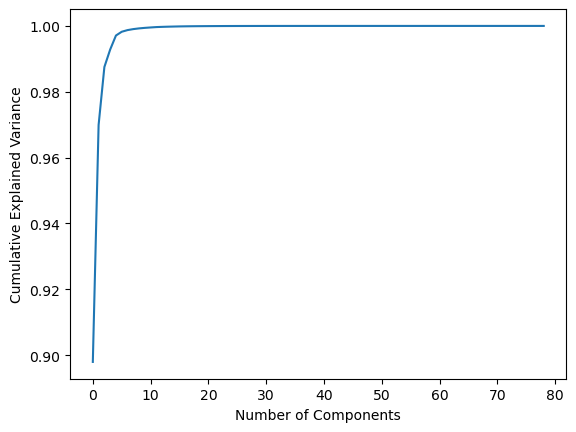

In [10]:
pca = PCA().fit(df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

PCA should cover about 95% of datasets variance. In our dataset, having 2 features already covers about 97% and 3 covers around 99%. As per testing performed I've settled with 10 as it gives best scoring for XGBoost model which we will see at the end of this notebook.

In [11]:
n_components = 10
pca = PCA(n_components)

pca.fit(X)
X_pca = pca.transform(X)

X_pca = pd.DataFrame(X_pca, columns=['PC{}'.format(i+1)for i in range(n_components)])
print(X_pca.shape)

(300, 10)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [13]:
results = {}  # for saving results in one place

## Logistic Regression

We will perform grid search testing for a few of available parameters. Model is nested in a pipeline alongside standard scaler, which will help us standardise data as we have a large range of values between different features.

In [14]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression())
])

In [15]:
param_grid = [
    {
        "logreg__solver": ["lbfgs", "sag"],
        "logreg__penalty": ("l2", None),
        "logreg__C": [0.1, 0.2, 0.5, 1, 2, 5, 10, 20]
    },
    {
        "logreg__solver": ["liblinear"],
        "logreg__penalty": ("l2", "l1"),
        "logreg__C": [0.1, 0.2, 0.5, 1, 2, 5, 10, 20]
    },
    {
        "logreg__solver": ["saga"],
        "logreg__penalty": ("elasticnet", "l2", "l1", None),
        "logreg__C": [0.1, 0.2, 0.5, 1, 2, 5, 10, 20]
    },
]

In [16]:
grid_logreg = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring="accuracy")
grid_logreg.fit(X_train, y_train)

C:\Users\PC\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\PC\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\PC\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\PC\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\PC\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\PC\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg', LogisticRegression())]),
             param_grid=[{'logreg__C': [0.1, 0.2, 0.5, 1, 2, 5, 10, 20],
                          'logreg__penalty': ('l2', None),
                          'logreg__solver': ['lbfgs', 'sag']},
                         {'logreg__C': [0.1, 0.2, 0.5, 1, 2, 5, 10, 20],
                          'logreg__penalty': ('l2', 'l1'),
                          'logreg__solver': ['liblinear']},
                         {'logreg__C': [0.1, 0.2, 0.5, 1, 2, 5, 10, 20],
                          'logreg__penalty': ('elasticnet', 'l2', 'l1', None),
                          'logreg__solver': ['saga']}],
             scoring='accuracy')

In [17]:
print(f"Best parameters: {grid_logreg.best_params_}")
print(f"Best training score: {grid_logreg.best_score_}")

Best parameters: {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}
Best training score: 0.6541666666666667


In [18]:
y_pred = grid_logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test dataset score: {accuracy}")

Test dataset score: 0.5666666666666667


Train accuracy is lower that test accuracy, so we don't need to worry about overfitting. However, results are underwhelming - 2/3 of all records in target vector are classified as 1, so if model had classified all tests as such then it would've done better than trying to predict based on available data.

For now we continue testing other models and see if any of them will be able to predict good stocks.

In [19]:
results["Logistic Regression"] = accuracy  # saving results to the dictionary for later comparison

## Support Vector Machines

Same approach as with logistic regression, run parameter grid search and scaler in a pipeline.

In [20]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC())
])

In [21]:
param_grid = [
    {
        "svm__C": [0.1, 0.2, 0.5, 1, 2, 4, 8, 12, 16, 20],
        "svm__kernel": ["linear", "poly", "rbf", "sigmoid"]
    }
]

In [22]:
grid_svm = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring="accuracy")
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC())]),
             param_grid=[{'svm__C': [0.1, 0.2, 0.5, 1, 2, 4, 8, 12, 16, 20],
                          'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}],
             scoring='accuracy')

In [23]:
print(f"Best parameters: {grid_svm.best_params_}")
print(f"Best training score: {grid_svm.best_score_}")

Best parameters: {'svm__C': 20, 'svm__kernel': 'rbf'}
Best training score: 0.7083333333333334


In [24]:
y_pred = grid_svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test dataset score: {accuracy}")

Test dataset score: 0.6


We can see again that training score is higher than testing, but testing score is still below our target. Similarly like with logistic regression then, using this model would yield us worse results in our investments than if we were to invest in the whole market.

In [25]:
results["SVM"] = accuracy

## Decision Tree Classifier

As we're still using sklearn, we don't have any reasons not to use its pipeline and grid search features.

In [26]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("tree", DecisionTreeClassifier())
])

In [27]:
param_grid = [
    {
        "tree__criterion": ["gini", "entropy", "log_loss"],
        "tree__max_depth": [4, 8, 12, 16, 20, 30, 40],
        "tree__ccp_alpha": [0, 0.5, 1, 1.5, 2, 2.5]
    }
]

In [28]:
grid_tree = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring="accuracy")
grid_tree.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('tree', DecisionTreeClassifier())]),
             param_grid=[{'tree__ccp_alpha': [0, 0.5, 1, 1.5, 2, 2.5],
                          'tree__criterion': ['gini', 'entropy', 'log_loss'],
                          'tree__max_depth': [4, 8, 12, 16, 20, 30, 40]}],
             scoring='accuracy')

In [29]:
print(f"Best parameters: {grid_tree.best_params_}")
print(f"Best training score: {grid_tree.best_score_}")

Best parameters: {'tree__ccp_alpha': 0, 'tree__criterion': 'entropy', 'tree__max_depth': 8}
Best training score: 0.675


In [30]:
y_pred = grid_tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test dataset score: {accuracy}")

Test dataset score: 0.5666666666666667


Results are in line with previous models, but testing results still aren't good enough.

We can see that basic models can't beat our 0.64 scoring that we set as a goal. Let's try then more sophisticated models and see if they will fare better.

In [31]:
results["Decision Tree"] = accuracy

## Neural network

We create a standard neural network model using Keras library. Input layer takes the same amount of features that we defined in PCA transformation and output will give us a target prediction. We use sigmoid activation function and binary crossentropy loss function for binary classification problems, and set-up an early stopping module for loss in validation dataset to avoid overfitting.

In [32]:
model = models.Sequential()

model.add(layers.Input((n_components,)))
model.add(layers.Dense(1000, activation="sigmoid"))
model.add(layers.Dense(64, activation="sigmoid"))
model.add(layers.Dense(32, activation="sigmoid"))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(optimizer="adam",
             loss="binary_crossentropy",
             metrics=["accuracy"])

callbacks = EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True)

In [33]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1000)                │          11,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          64,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,177 (301.47 KB)

 Trainable params: 77,177 (301.47 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
history = model.fit(X_train, y_train, epochs=1000, batch_size=100, validation_data=[X_test, y_test], callbacks=callbacks)

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.3442 - loss: 0.8812 - val_accuracy: 0.4000 - val_loss: 0.7134
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4646 - loss: 0.7101 - val_accuracy: 0.5833 - val_loss: 0.6777
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6717 - loss: 0.6533 - val_accuracy: 0.6000 - val_loss: 0.6737
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6533 - loss: 0.6441 - val_accuracy: 0.6000 - val_loss: 0.6757
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6608 - loss: 0.6364 - val_accuracy: 0.6000 - val_loss: 0.6789
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6558 - loss: 0.6379 - val_accuracy: 0.6000 - val_loss: 0.6816
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6383 - loss: 0.6495 - val_accuracy: 0.6167 - val_loss: 0.6836
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6517 - loss: 0.6406 - val_accuracy: 0.6000 - v

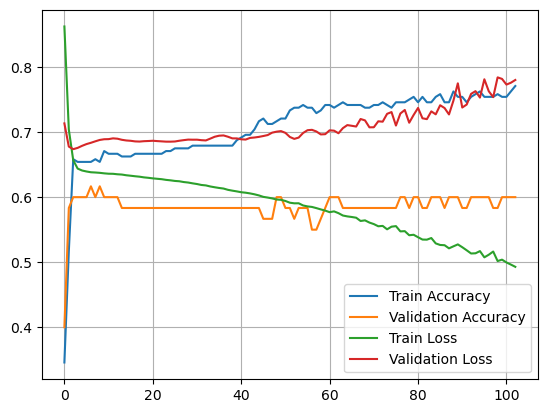

In [35]:
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.grid()

In [36]:
train_loss, train_acc = model.evaluate(X_train, y_train, batch_size=100)
train_loss, train_acc

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6733 - loss: 0.6367


(0.6450470685958862, 0.6541666388511658)

In [37]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=100)
test_loss, test_acc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6000 - loss: 0.6737


(0.6737443804740906, 0.6000000238418579)

Test accuracy for neural network arrived at 0.6 - better than logistic regression and decision trees, but same as SVM. We can always try different layer combinations, but I don't expect that results will increase substantially.

For NN we can also see model's prediction confidence, to see how likely model predicted each record to have a 1 or 0 target.

In [38]:
results["Neural Network"] = test_acc

In [39]:
y_predict = model.predict(X_test, batch_size=100)
y_predict

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


array([[0.6134181 ],
       [0.6134181 ],
       [0.61451954],
       [0.6140355 ],
       [0.6134181 ],
       [0.61399233],
       [0.6134181 ],
       [0.5679591 ],
       [0.613838  ],
       [0.5894133 ],
       [0.6085057 ],
       [0.6126957 ],
       [0.57557714],
       [0.6098118 ],
       [0.6134181 ],
       [0.6133238 ],
       [0.6134181 ],
       [0.6132662 ],
       [0.61320543],
       [0.614656  ],
       [0.55651486],
       [0.6134354 ],
       [0.6140202 ],
       [0.6140202 ],
       [0.6138055 ],
       [0.6142186 ],
       [0.6134181 ],
       [0.6134181 ],
       [0.53494525],
       [0.60713875],
       [0.60895854],
       [0.61442685],
       [0.60998213],
       [0.6142433 ],
       [0.61330605],
       [0.61398315],
       [0.6140334 ],
       [0.61352223],
       [0.6122675 ],
       [0.6135025 ],
       [0.6129958 ],
       [0.5326303 ],
       [0.61361927],
       [0.61317486],
       [0.54753745],
       [0.61385155],
       [0.6134181 ],
       [0.612

We can see that our model is always predicting an increase but with very low confidence as all predictions hover around 0.6-0.63. In confusion matrix below we see that all records with target 1 have been correctly classified and all 0 targets were not, ultimately giving us the same score as in testing (36/60=0.6).

Neural network model is still not reaching our set goal so we wouldn't be able to use it in "production" environment.

Text(0.5, 1.0, 'Confusion atrix')

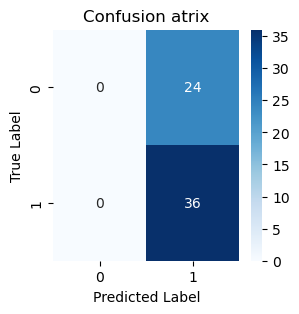

In [40]:
y_pred = np.round(y_predict)
matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(3,3))
sns.heatmap(matrix,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=range(2),
            yticklabels=range(2),
           )
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion atrix")

## XGBoost

With XGBoost and LightGBM we can again use pipelines and grid search from scikit so we make use of them.

In [41]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", xgb.XGBClassifier())
])

In [42]:
parameters = {'xgb__n_estimators' :[19, 30, 40, 90, 150],
              'xgb__max_depth':[2, 4, 6, 8, 10, 12, 30],
              'xgb__subsample': [0.75, 1],
              'xgb__colsample_bytree' : [0.5, 0.75],
              'xgb__tree_method' : ['hist'],
              'xgb__device' : ['cuda']
             }

In [43]:
grid_xgb = GridSearchCV(pipeline, parameters, cv=5, scoring="accuracy")
grid_xgb.fit(X_train, y_train)

C:\Users\PC\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:59:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
C:\Users\PC\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:59:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
C:\Users\PC\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:59:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
C:\Users\PC\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarnin

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=No...
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             param_grid={'xgb__colsample_bytree': [0.5, 0.75],
                         'xgb__device': ['cuda'],
                         'xgb__max_depth': [2, 4, 6, 8, 10, 12, 30],
                         'xgb__n_estimators': [19, 30, 40, 90, 150],
                         'xgb__subsample': [0.75, 1],
                         'xgb__tree_method': ['hist']},
             scoring='accuracy')

In [44]:
print("Best CV params", grid_xgb.best_params_)
print("Best CV accuracy", grid_xgb.best_score_)
print("Test accuracy of best grid search hypers:", grid_xgb.score(X_test, y_test))

Best CV params {'xgb__colsample_bytree': 0.5, 'xgb__device': 'cuda', 'xgb__max_depth': 2, 'xgb__n_estimators': 150, 'xgb__subsample': 1, 'xgb__tree_method': 'hist'}
Best CV accuracy 0.6666666666666667
Test accuracy of best grid search hypers: 0.6166666666666667


XGBoost gave us the best result so far, even if only 0.017 points above SVM and NN. This is still not good enough result so out last hope is in LightGBM...

In [45]:
results["XGBoost"] = grid_xgb.score(X_test, y_test)

## LightGBM

In [46]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("lgbm", lgb.LGBMClassifier())
])

In [47]:
parameters = {'lgbm__n_estimators' :[19, 30, 40, 90, 150],
              'lgbm__max_depth':[2, 4, 6, 8, 10, 12, 30],
              'lgbm__subsample': [0.75, 1],
              'lgbm__num_leaves' : [20, 30, 40],
              #'lgbm__device' : ['cuda']  <- crashes when fitting
             }

In [48]:
grid_lgbm = GridSearchCV(pipeline, parameters, cv=5, scoring="accuracy")
grid_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 125, number of negative: 67
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 192, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.651042 -> initscore=0.623621
[LightGBM] [Info] Start training from score 0.623621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lgbm', LGBMClassifier())]),
             param_grid={'lgbm__max_depth': [2, 4, 6, 8, 10, 12, 30],
                         'lgbm__n_estimators': [19, 30, 40, 90, 150],
                         'lgbm__num_leaves': [20, 30, 40],
                         'lgbm__subsample': [0.75, 1]},
             scoring='accuracy')

In [49]:
print("Best CV params", grid_lgbm.best_params_)
print("Best CV accuracy", grid_lgbm.best_score_)
print("Test accuracy of best grid search hypers:", grid_lgbm.score(X_test, y_test))

Best CV params {'lgbm__max_depth': 2, 'lgbm__n_estimators': 19, 'lgbm__num_leaves': 20, 'lgbm__subsample': 0.75}
Best CV accuracy 0.6791666666666667
Test accuracy of best grid search hypers: 0.55


...and we get the worst score so far.

In [50]:
results["LightGBM"] = grid_lgbm.score(X_test, y_test)

## Results

In [51]:
results

{'Logistic Regression': 0.5666666666666667,
 'SVM': 0.6,
 'Decision Tree': 0.5666666666666667,
 'Neural Network': 0.6000000238418579,
 'XGBoost': 0.6166666666666667,
 'LightGBM': 0.55}

Ultimately results from different models range from 0.55 to 0.62, which was not enough to even reach our set goal of 0.64. Best next steps to take here would be either to look again to the data that we have and try to improve it, get more data for testing, or preferrably both.

On data analysis part, we could look for more features that we can get rid off without hurting data quality, try to combine some others that are dependant on each other or try to get some new data points like financial ratios. For more data we can keep pulling new issuers daily to increase our volume, or get paid subscription to get more dates and markets from around the world, rather than be confined to US data for last 5 years.

Note: in a different notebook I managed to achieve XGBoost score of 0.68 using raw data and PCA with 85 components.